# Build keypoint code

Then, use it sequentially on small windows to stitch tracklets together

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
import pandas as pd
%load_ext autoreload
%autoreload 2

from DLC_for_WBFM.utils.feature_detection.utils_features import *
from DLC_for_WBFM.utils.feature_detection.utils_tracklets import *
from DLC_for_WBFM.utils.feature_detection.utils_detection import *
from DLC_for_WBFM.utils.feature_detection.visualization_tracks import *
from DLC_for_WBFM.utils.feature_detection.feature_pipeline import *
from DLC_for_WBFM.utils.feature_detection.utils_affine import *
from DLC_for_WBFM.utils.feature_detection.class_reference_frame import PreprocessingSettings
import pickle
from collections import defaultdict


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1306]:
which_suffix = 'prealigned'

fname = f'clust_df_dat_{which_suffix}.pickle'
with open(fname, 'rb') as f:
    clust_df = pickle.load(f)
    
fname = f'frame_dat_{which_suffix}.pickle'
with open(fname, 'rb') as f:
    all_frames = pickle.load(f)

In [27]:

# Getting keypoints
def separate_keypoints_and_tracklets(clust_df, start_ind, window_length, 
                                     min_tracklet_overlap=3,
                                     min_required_keypoints=10):
    """
    For a given window, separates tracklets into two categories:
        Keypoints, which are tracked in the entire window
        Tracklets, which have at least 'min_tracklet_overlap' frames in the window
    """
    
    is_keypoint = []
    is_tracklet = []
    this_window = list(range(start_ind, start_ind + window_length))
    for i, row in enumerate(clust_df['slice_ind']):
        overlap_ind = np.array([i in this_window for i in row])
        num_overlap = np.count_nonzero(overlap_ind)
        if num_overlap < min_tracklet_overlap:
            continue
        elif num_overlap == window_length:
            is_keypoint.append(i)
        elif num_overlap <= (window_length-min_tracklet_overlap):
            # If it is nearly the entire window, then it can't match with anything
            is_tracklet.append(i)
            
    kp_df = clust_df.iloc[is_keypoint]
    tracklet_df = clust_df.iloc[is_tracklet]
    
    if len(kp_df) < min_required_keypoints:
        print(f"Warning, few keypoints ({len(kp_df)}) detected")
    
    return kp_df, tracklet_df

In [1210]:
# Building features
def calc_vectors(this_neuron, kp_df, slice_ind):
    one_neuron_vectors = []
    this_neuron = np.array(this_neuron)
    for _, kp in kp_df.iterrows():
        # The tracks are long, so only do the point at slice_ind
        kp_ind = kp['slice_ind'].index(slice_ind)
        kp_neuron = np.array(kp['all_xyz'][kp_ind])
        one_neuron_vectors.append(this_neuron - kp_neuron)
        
    return one_neuron_vectors


def calc_features_from_vectors(one_neuron_vectors, only_diagonal):
    """Todo: refactor to be smarter with inner product"""
    n = len(one_neuron_vectors)
    one_neuron_features = []
    for i1 in range(n):
        for i2 in range(i1, n):
            v1, v2 = one_neuron_vectors[i1], one_neuron_vectors[i2]
            one_neuron_features.append(np.dot(v1, v2))
            if only_diagonal:
                break
    
    return one_neuron_features


def calc_all_tracklet_features(kp_df, tracklet_df, start_ind, window_length, only_diagonal=True, verbose=1):
    """
    Processes tracklet dataframe, returning a list of features
    
    The indices of this list correspond to the overlap with the window
    """
    
    this_window = list(range(start_ind, start_ind + window_length))
    all_tracklet_features = []
    if verbose >= 1:
        print("Calculating features for all tracklets")
    for _, tracklet in tqdm(tracklet_df.iterrows(), total=len(tracklet_df)):
        this_tracklet_features = []
        for global_ind in this_window:
            if global_ind in tracklet['slice_ind']:
                tracklet_ind = tracklet['slice_ind'].index(global_ind)
                this_neuron = tracklet['all_xyz'][tracklet_ind]
            else:
                continue
            these_vectors = calc_vectors(this_neuron, kp_df, global_ind)
            tmp = calc_features_from_vectors(these_vectors, only_diagonal)
            this_tracklet_features.append(tmp)
        all_tracklet_features.append(this_tracklet_features)
    
    return all_tracklet_features

In [1406]:
# Building low-d space and classifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA, MiniBatchSparsePCA, FastICA
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope

def calc_one_stable_space(x,
                          transformer_func=MiniBatchSparsePCA,#FastICA
                          transformer_opt={'alpha':0.01},#{'whiten':True, 'max_iter':1000},
                          classifier_func=EllipticEnvelope, 
                          classifier_opt={}):
    """
    Uses last 2 PCA modes
    
    Can also use: PCA
    
    Can also use: classifier_func=OneClassSVM
    suggested settings: classifier_opt={nu=0.1, kernel='rbf'}
    """
    # Build space
    x = np.array(x)
    # TODO: Keep the std original?
    x_std = StandardScaler(with_std=False).fit_transform(x)
    transformer = transformer_func()
    transformer.fit(x_std)
    # Build classifier
    # See: https://scikit-learn.org/stable/modules/outlier_detection.html
    x_projected = transformer.transform(x)
    classifier = classifier_func(**classifier_opt)
    classifier.fit(x_projected[:,-2:])
    
    return transformer, classifier


def calc_feature_subset(tracklet_features, verbose=0):
    """Takes the features that are on average closest"""
    all_feature_subsets = {}
    for i, these_features in enumerate(all_tracklet_features):
        these_features = np.array(these_features)
        sz = these_features.shape
        max_features = sz[0]-1
        if sz[1] > max_features:
            if verbose >= 2: 
                print(f"Too few tracklet neurons, creating a subset of {max_features} features")
            these_means = np.mean(these_features, axis=0)
            sorted_ind = np.argsort(these_means)
            good_ind = sorted_ind[:max_features]

            if verbose >= 2: 
                print(f"Features retained: {good_ind}")
                
            all_feature_subsets[i] = good_ind
    return all_feature_subsets


def calc_all_subspaces(all_tracklet_features):
    """
    Calculates all stable subspaces
    Note that it doesn't return the features of the tracklet in its own subspace
    [only returns the classifier]
    """
    
    all_feature_subsets = calc_feature_subset(all_tracklet_features)
    
    all_transformers, all_classifiers = [], []
    for i, tracklet_features in tqdm(enumerate(all_tracklet_features), total=len(all_tracklet_features)):
        if i in all_feature_subsets:
            ind = all_feature_subsets[i]
            tmp_features = np.array(tracklet_features)[:,ind]
        else:
            tmp_features = np.array(tracklet_features)
        this_transformer, this_classifier = calc_one_stable_space(tmp_features)
        all_transformers.append(this_transformer)
        all_classifiers.append(this_classifier)
    
    return all_transformers, all_classifiers, all_feature_subsets

In [1407]:
# Classifying all tracklets and stitching
def calc_tracklet_label(other_x, this_t, this_c):
    """Greedy tracklet labeling based on voting of each individual neuron within the tracklet"""
    these_other, these_confidences = [], []
    for i1, x in other_x.items():
        x_t = this_t.transform(x)
        pred = this_c.predict(x_t[:,-2:])
        conf = np.count_nonzero(pred==1)/len(pred)
        if conf > 0.0:
            these_other.append(i1)
            these_confidences.append(conf)
    
    return these_other, these_confidences


def match_tracklets(tracklet_df, all_tracklet_features, all_transformers, all_classifiers, all_feature_subsets):
    
    all_matches = []
    num_tracklets = len(tracklet_df)
    for i0, (_,this_tracklet) in tqdm(enumerate(tracklet_df.iterrows()), total=len(tracklet_df)):
        # Don't even attempt a match if the neurons are simultaneously identified
        # TODO: should I really treat the tracklets as 100% accurate?
        this_t, this_c = all_transformers[i0], all_classifiers[i0]
        if i0 in all_feature_subsets:
            feature_subset = all_feature_subsets[i0]
        else:
            feature_subset = None
        these_ind = set(this_tracklet['slice_ind'])
        other_x = {}
        for i1 in range(num_tracklets):
            if i0==i1:
                continue
            other_tracklet = tracklet_df.iloc[i1]
            other_ind = set(other_tracklet['slice_ind'])
            if len(these_ind.intersection(other_ind))==0:
                other_x_tmp = np.array(all_tracklet_features[i1])
                if feature_subset is None:
                    other_x[i1] = other_x_tmp
                else:
                    other_x[i1] = other_x_tmp[:,feature_subset]
                    
        these_other, these_confidences = calc_tracklet_label(other_x, this_t, this_c)
        # Cast in graph format
        m = [[i0, i1, c] for i1, c in zip(these_other, these_confidences)]
        all_matches.extend(m)
    
    return all_matches

## Utilities

In [1298]:
def get_indices_of_tracklet(i):
    ind = tracklet_df['slice_ind'].iloc[i]
    return ind

def get_index_overlap(i0, i1):
    ind0 = set(get_indices_of_tracklet(i0))
    ind1 = set(get_indices_of_tracklet(i1))
    return ind0.intersection(ind1)

def get_index_overlap_list(all_i, verbose=1):
    n = len(all_i)
    for i0 in range(n):
        for i1 in range(i0+1,n):
            overlap = get_index_overlap(all_i[i0], all_i[i1])
            if len(overlap) > 1 or verbose >= 1:
                print(f"Overlap between {all_i[i0]} and {all_i[i1]}:")
                print(overlap)

In [1470]:
def visualize_tracklet_in_body(i_tracklet, i_frame, to_plot=False):
    if type(i_tracklet)!=list:
        i_tracklet = [i_tracklet]
        
    for i_t in i_tracklet:
        tracklet_ind = get_indices_of_tracklet(i_t)
        if not i_frame in tracklet_ind:
            print(f"{i_frame} is not in tracklet; try one of {tracklet_ind}")
    
    # Get this tracklet
    tracklet_xyz = []
    for i_t in i_tracklet:
        try:
            local_ind = tracklet_df['slice_ind'].iloc[i_t].index(i_frame)
            tracklet_xyz.append(tracklet_df['all_xyz'].iloc[i_t][local_ind])
        except:
            print(f"{i_frame} not in tracklet {i_t}")
            if to_error:
                raise ValueError
    
    # Get keypoints
    kp_xyz = []
    for i_kp in range(len(kp_df)):
        local_ind = kp_df['slice_ind'].iloc[i_kp].index(i_frame)
        kp_xyz.append(kp_df['all_xyz'].iloc[i_kp][local_ind])
    
    # Get all other neurons
    this_frame = all_frames[i_frame]
    _, pc_neurons, pc_tree = build_neuron_tree(this_frame.neuron_locs, False)
    pc_neurons.paint_uniform_color([0.5,0.5,0.5])
    
    # Color the tracklet and keypoint neurons
    for xyz in tracklet_xyz:
        [k,idx,_] = pc_tree.search_knn_vector_3d(xyz, 1)
        np.asarray(pc_neurons.colors)[idx[:], :] = [1, 0, 0]
    for xyz in kp_xyz:
        [k,idx,_] = pc_tree.search_knn_vector_3d(xyz, 1)
        np.asarray(pc_neurons.colors)[idx[:], :] = [0, 0, 1]
    
    if to_plot:
        o3d.visualization.draw_geometries([pc_neurons])
    
    return pc_neurons
    
    

# Toy data

In [1023]:
start_ind = 0
window_length = 50

# Generate keypoints with various amounts of noise
kp_locs = [[-10,-10], [-10,10],[10,10],[0,-10],[0,10]]
kp_sigma = [0.1, 0.1, 1.0, 1.0, 1.0]
kp_dat = []
sz = (window_length, 2)
kp_ind = []
for xyz, s in zip(kp_locs, kp_sigma):
    kp_ind.append(list(range(sz[0])))
    kp_dat.append(np.random.normal(loc=xyz, scale=s, size=sz))

# Generate unknown points and split them
unknown_loc = [[0,0], [0.5,0.5]]
unknown_sigma = [0.1, 0.1]
unknown_dat = []
split = 3
sz0 = (split,2)
sz1 = (window_length-split,2)
unknown_ind = []
for xyz, s in zip(unknown_loc, unknown_sigma):
    unknown_ind.append(list(range(sz0[0])))
    unknown_ind.append(list(range(sz0[0], sz1[0])))
    unknown_dat.append(np.random.normal(loc=xyz, scale=s, size=sz0))
    unknown_dat.append(np.random.normal(loc=xyz, scale=s, size=sz1))
    
# Concatenate    
all_dat = kp_dat + unknown_dat
all_ind = kp_ind + unknown_ind

# Apply an offset
magnitude = 10
for i_pt in range(sz[0]):
    offset = magnitude*(2*np.random.rand(2)-1)
    for dat, ind in zip(all_dat, all_ind):
        if i_pt in ind:
            i_local = ind.index(i_pt)
            dat[i_local] += offset

<IPython.core.display.Javascript object>


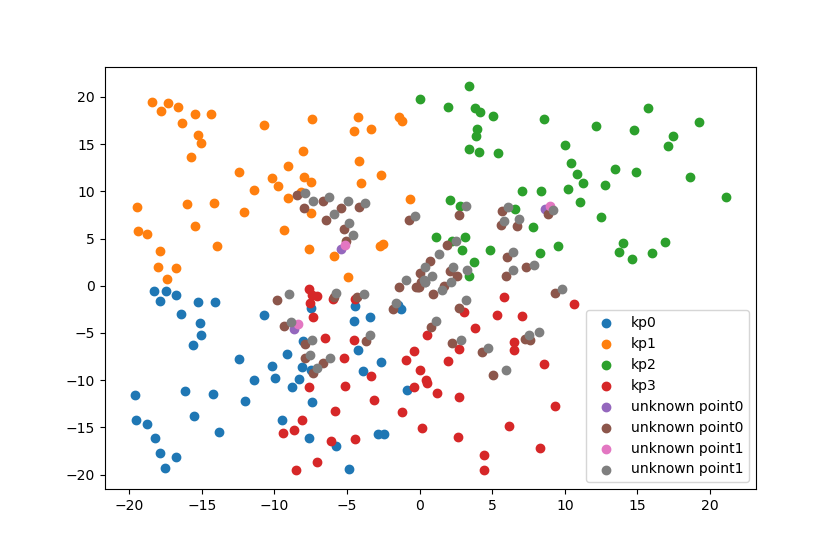

In [1024]:
%matplotlib notebook
plt.scatter(kp_dat[0][:,0],kp_dat[0][:,1], label='kp0')
plt.scatter(kp_dat[1][:,0],kp_dat[1][:,1], label='kp1')
plt.scatter(kp_dat[2][:,0],kp_dat[2][:,1], label='kp2')
plt.scatter(kp_dat[3][:,0],kp_dat[3][:,1], label='kp3')
plt.scatter(unknown_dat[0][:,0],unknown_dat[0][:,1], label='unknown point0')
plt.scatter(unknown_dat[1][:,0],unknown_dat[1][:,1], label='unknown point0')
plt.scatter(unknown_dat[2][:,0],unknown_dat[2][:,1], label='unknown point1')
plt.scatter(unknown_dat[3][:,0],unknown_dat[3][:,1], label='unknown point1')
plt.legend()

In [1026]:
df_dict = {'all_xyz':all_dat, 'slice_ind':all_ind}
new_df = pd.DataFrame.from_dict(df_dict)

In [1027]:
kp_df, tracklet_df = separate_keypoints_and_tracklets(new_df, start_ind, window_length)
assert len(kp_df)==5
assert len(tracklet_df)==4

Warning, few keypoints (5) detected


In [1028]:
all_tracklet_features = calc_all_tracklet_features(kp_df, tracklet_df, start_ind, window_length)
assert len(all_tracklet_features)==4
assert len(all_tracklet_features[0])==split
assert len(all_tracklet_features[0][0])==5

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 137.97it/s]

Calculating features for all tracklets


In [1029]:
all_transformers, all_classifiers, all_feature_subsets = calc_all_subspaces(all_tracklet_features)

100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.82it/s]


In [1030]:
all_matches = match_tracklets(tracklet_df, all_tracklet_features, all_transformers, all_classifiers, all_feature_subsets)
all_matches

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<?, ?it/s]


[[0, 1, 0.045454545454545456],
 [0, 3, 0.022727272727272728],
 [1, 0, 0.6666666666666666],
 [2, 1, 0.06818181818181818],
 [2, 3, 0.06818181818181818],
 [3, 2, 1.0]]

In [1031]:
print(np.round(all_transformers[1].components_.T,2))

[[ 0.02 -0.11  0.03 -0.67  0.  ]
 [-0.01 -0.13  0.25  0.   -0.5 ]
 [ 0.84  0.3  -0.03  0.   -0.05]
 [ 0.01  0.11  0.96  0.    0.1 ]
 [-0.54  0.93 -0.14 -0.74 -0.86]]


In [1032]:
# print(all_transformers[1].explained_variance_)

## Simplified neuron data: 4 tracklets which are actually split keypoints


In [1523]:
start_ind = 200
window_length = 50
only_diagonal = True

In [1524]:
kp_df_raw, _ = separate_keypoints_and_tracklets(clust_df, start_ind, window_length, min_tracklet_overlap=7)

In [1572]:
# Split the tracks
split = 220
include_idx = [1,3]
mask = np.zeros(len(kp_df_raw),dtype=bool)
mask[include_idx] = True
tmp_df = kp_df_raw[mask]
all_xyz, all_ind = [], []
for _, row in tmp_df.iterrows():
    local_ind = row['slice_ind'].index(split)
    all_ind.append(row['slice_ind'][:local_ind])
    all_ind.append(row['slice_ind'][local_ind:])
    all_xyz.append(row['all_xyz'][:local_ind])
    all_xyz.append(row['all_xyz'][local_ind:])

df_dict = {'all_xyz':all_xyz, 'slice_ind':all_ind}
tracklet_df = pd.DataFrame.from_dict(df_dict)

# Get the rest
kp_df = kp_df_raw[~mask]

In [1577]:
all_tracklet_features = calc_all_tracklet_features(kp_df, tracklet_df, start_ind, window_length, only_diagonal)

  0%|                                                                                             | 0/4 [00:00<?, ?it/s]

Calculating features for all tracklets


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.74it/s]


In [1578]:
print("Number of tracklets found: ", len(all_tracklet_features))
print("Length of an example tracklet: ", len(all_tracklet_features[0]))
print("Number of keypoint features calculated: ", len(all_tracklet_features[3][0]))

Number of tracklets found:  4
Length of an example tracklet:  20
Number of keypoint features calculated:  54


In [1573]:
visualize_tracklet_in_body([0,2],200, True)

PointCloud with 149 points.

<IPython.core.display.Javascript object>


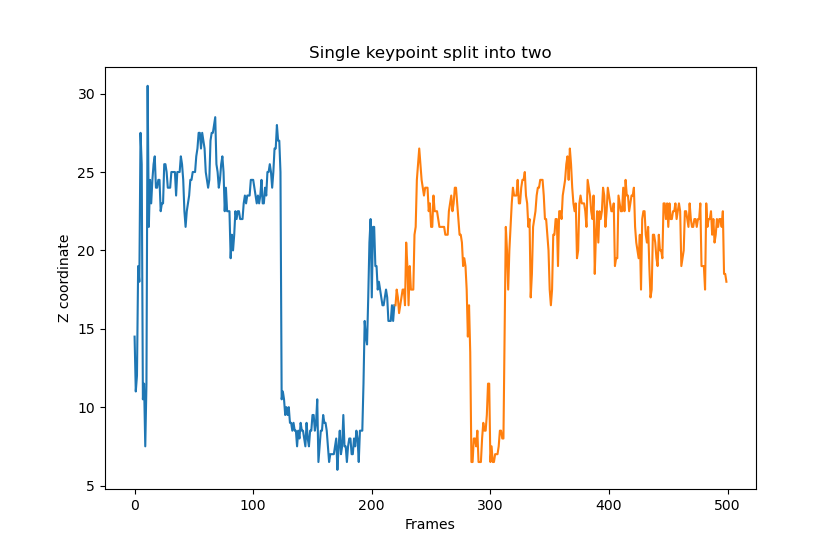

Text(0.5, 1.0, 'Single keypoint split into two')

In [1579]:
%matplotlib notebook
i = 2
x = tracklet_df['slice_ind'][i]
plt.plot(x, np.array(tracklet_df['all_xyz'][i])[:,0], label='First half')
x = tracklet_df['slice_ind'][i+1]
plt.plot(x, np.array(tracklet_df['all_xyz'][i+1])[:,0], label='Second half')
plt.xlabel("Frames")
plt.ylabel("Z coordinate")
plt.title("Single keypoint split into two")

# Test it on neuron data

In [1583]:
start_ind = 200
window_length = 50
only_diagonal = True

In [1584]:
kp_df, tracklet_df = separate_keypoints_and_tracklets(clust_df, start_ind, window_length, min_tracklet_overlap=7)

In [1585]:
all_tracklet_features = calc_all_tracklet_features(kp_df, tracklet_df, start_ind, window_length, only_diagonal)

  1%|▍                                                                                  | 1/191 [00:00<00:29,  6.49it/s]

Calculating features for all tracklets


100%|█████████████████████████████████████████████████████████████████████████████████| 191/191 [00:13<00:00, 13.76it/s]


In [1586]:
print("Number of tracklets found: ", len(all_tracklet_features))
print("Length of an example tracklet: ", len(all_tracklet_features[0]))
print("Number of keypoint features calculated: ", len(all_tracklet_features[3][0]))

Number of tracklets found:  191
Length of an example tracklet:  38
Number of keypoint features calculated:  56


In [1216]:
# tracklet_df

## Get the candidate matches

In [1374]:
all_transformers, all_classifiers, all_feature_subsets = calc_all_subspaces(all_tracklet_features)

100%|█████████████████████████████████████████████████████████████████████████████████| 266/266 [04:25<00:00,  1.00it/s]


In [1375]:
all_matches = match_tracklets(tracklet_df, all_tracklet_features, all_transformers, all_classifiers, all_feature_subsets)

100%|█████████████████████████████████████████████████████████████████████████████████| 266/266 [00:30<00:00,  8.76it/s]


## Look at the specific PCA properties

In [1209]:
# %matplotlib notebook
# print(all_transformers[0].explained_variance_)
# plt.plot(np.log(all_transformers[1].explained_variance_), 'o')
# print(np.round(all_transformers[0].components_[-1],2))
# plt.plot(all_transformers[2].components_.T[:,-2:])
# plt.plot(all_transformers[2].components_.T)
# plt.title("PCA modes")

In [1401]:
# Look at time series of features for a neuron
%matplotlib inline
def f(n0=0, n1=1, which_feature=0):
    all_x0 = all_tracklet_features[n0]
    x0 = np.array(all_x0)[:,which_feature]
    plt.plot(x0, label=f"neuron {n0}")
    all_x1 = all_tracklet_features[n1]
    x1 = np.array(all_x1)[:,which_feature]
    plt.plot(x1, label=f"neuron {n1}")
    
    p = ks_2samp(x0, x1)[1]
    
    plt.xlabel("Tracklet frames (NOT ALIGNED)")
    plt.title(f"Feature {which_feature}; p={p}")
    plt.legend()
    plt.show()
    
#     print("Chosen subset:")
#     print(all_feature_subsets[n0])
#     print(which_feature in all_feature_subsets[n0])

num_features = np.array(all_tracklet_features[0]).shape[1] - 1
num_n = len(all_tracklet_features) - 1
interact(f, n0=(0,num_n), n1=(0,num_n), which_feature=(0,num_features))

interactive(children=(IntSlider(value=0, description='n0', max=265), IntSlider(value=1, description='n1', max=…

<function __main__.f(n0=0, n1=1, which_feature=0)>

In [1302]:
# Look at histogram of p values for a neuron match
%matplotlib inline
num_features = np.array(all_tracklet_features[0]).shape[1] - 1
num_n = len(all_tracklet_features) - 1

def f(n0=0, n1=1):
    
    all_x0 = all_tracklet_features[n0]
    all_x1 = all_tracklet_features[n1]
    all_p = []
    for which_feature in range(num_features):
        x0 = np.array(all_x0)[:,which_feature]
        x1 = np.array(all_x1)[:,which_feature]
        all_p.append(ks_2samp(x0, x1)[1])
    plt.hist(all_p, bins=20, range=(0,1))
    
    plt.xlabel("P values")
    plt.title(f"Distribution across features (mean={np.mean(all_p)})")
#     plt.legend()
    plt.show()

interact(f, n0=(0,num_n), n1=(0,num_n), which_feature=(0,num_features))

interactive(children=(IntSlider(value=0, description='n0', max=265), IntSlider(value=1, description='n1', max=…

<function __main__.f(n0=0, n1=1)>

In [1265]:
# Alternative matches: KS test on ALL features

num_failures_allowed = 20 # First couple can fail
num_matches_needed = 100

# First, calculate outliers
# Uses the std of a single feature
feature0_std = [np.std(np.array(t)[:,0]) for t in all_tracklet_features]
av, std = np.mean(feature0_std), np.std(feature0_std)
max_std = av + 2*std
is_outlier = (feature0_std > max_std)

# Then, calculate matches
n = len(all_tracklet_features)
test_matches = np.zeros((n,n))
for i0 in tqdm(range(n)):
    if is_outlier[i0]:
        continue
    for i1 in range(i0+1, n):
        if is_outlier[i1]:
            continue
        
        x0 = np.array(all_tracklet_features[i0])
        x1 = np.array(all_tracklet_features[i1])
        
        num_failed = 0
        num_matched = 0
        num_features = range(x0.shape[1])
        for i_feature in num_features:
            f0, f1 = x0[:,i_feature], x1[:,i_feature]
            p = ks_2samp(f0, f1)[1]
            if p > 0.01:
                num_matched += 1
            else:
                num_failed += 1
            if num_matched >= num_matches_needed or i_feature==num_features:
#                 print(f"neuron {i0} matched with {i1} at p={p}")
                test_matches[i0,i1] = 1
                break
            if num_failed > num_failures_allowed:
                break

100%|█████████████████████████████████████████████████████████████████████████████████| 266/266 [03:16<00:00,  1.36it/s]


In [1271]:
# Alternative matches: KS test on ALL features
# Similar to above, but this saves ALL test results

# First, calculate outliers
# Uses the std of a single feature
feature0_std = [np.std(np.array(t)[:,0]) for t in all_tracklet_features]
av, std = np.mean(feature0_std), np.std(feature0_std)
max_std = av + 2*std
is_outlier = (feature0_std > max_std)

# Then, calculate matches
n = len(all_tracklet_features)
test_matches = np.zeros((n,n))
for i0 in tqdm(range(n)):
    if is_outlier[i0]:
        continue
    for i1 in range(i0+1, n):
        if is_outlier[i1]:
            continue
        
        x0 = np.array(all_tracklet_features[i0])
        x1 = np.array(all_tracklet_features[i1])
        
        these_p = []
        num_features = range(x0.shape[1])
        for i_feature in num_features:
            f0, f1 = x0[:,i_feature], x1[:,i_feature]
            these_p.append(ks_2samp(f0, f1)[1])
        test_matches[i0,i1] = np.mean(these_p)

100%|█████████████████████████████████████████████████████████████████████████████████| 266/266 [04:54<00:00,  1.11s/it]


<IPython.core.display.Javascript object>


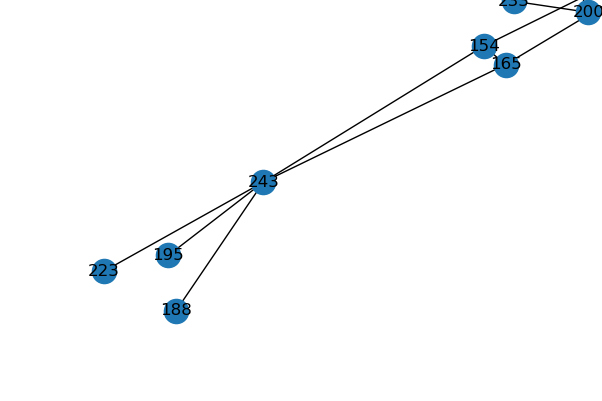

In [1300]:
%matplotlib notebook
thresholded_matches = test_matches * (test_matches>0.2)
DG = nx.from_numpy_array(thresholded_matches)
nx.draw(DG, with_labels=True)

In [1372]:
visualize_tracklet_in_body([206,130],78, True)

78 is not in tracklet; try one of 1573                    [77, 78, 79, 80, 81, 82, 83, 84]
1370    [66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77]
Name: slice_ind, dtype: object
78 not in tracklet 130


PointCloud with 152 points.

In [1363]:
print(get_indices_of_tracklet(130))
print(get_indices_of_tracklet(206))

[66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77]
[77, 78, 79, 80, 81, 82, 83, 84]


In [1304]:
get_index_overlap_list([18, 0, 111])

Overlap between 18 and 0:
{19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60}
Overlap between 18 and 111:
set()
Overlap between 0 and 111:
set()


In [1287]:
# from scipy.stats import anderson_ksamp

# %matplotlib inline
# x0 = np.array(all_tracklet_features[103])[:,0]
# x1 = np.array(all_tracklet_features[101])[:,0]
# plt.plot(x0)
# plt.plot(x1)
# print(ks_2samp(x0,x1))
# print(anderson_ksamp([x0,x1]))

<IPython.core.display.Javascript object>


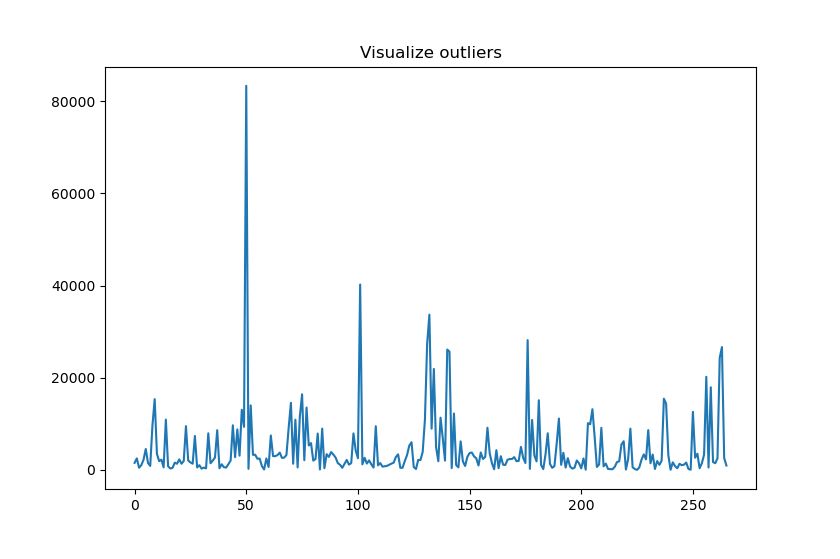

Text(0.5, 1.0, 'Visualize outliers')

In [1288]:
%matplotlib notebook
all_std = [np.std(np.array(t)[:,0]) for t in all_tracklet_features]
plt.plot(all_std)
np.mean(all_std), np.std(all_std)
plt.title("Visualize outliers")

## Visualize the matches

In [1092]:
start_ind = 0
min_strength = 0.8

print(tracklet_df['slice_ind'].iloc[start_ind])
for m in all_matches:
    if m[-1] < min_strength:
        continue
    if m[0]==start_ind:
        print("Match:")
        print(m)
        print(tracklet_df['slice_ind'].iloc[m[1]])
        print("")
    elif m[1]==start_ind:
        print("Opposite match:")
        print(m)
        print(tracklet_df['slice_ind'].iloc[m[0]])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]
Opposite match:
[113, 0, 0.9230769230769231]
[64, 65, 66, 67, 68, 69, 70, 71]
Opposite match:
[136, 0, 1.0]
[67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119]
Opposite match:
[154, 0, 0.9230769230769231]
[69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124]


In [1383]:
# Alternative matching: KS test of last 2 PCA modes

def match_func(x1,x2):
    p = ks_2samp(x1[:,-1], x2[:,-1])[1] * ks_2samp(x1[:,-2], x2[:,-2])[1]
#     return p
    if p > 0.05:
        return p
    else:
        return 0

n = len(all_tracklet_features)
test_matches = np.zeros((n,n))
for i0 in tqdm(range(n)):
    for i1 in range(n):
        if i0==i1:
            continue
        
        t = all_transformers[i0]
        c = all_classifiers[i0]
        if i0 in all_feature_subsets:
            s = all_feature_subsets[i0]
        else:
            s = None

        x = all_tracklet_features[i0]
        if s is not None:
            x = np.array(x)[:,s]
        x_t0 = t.transform(x)

        x = all_tracklet_features[i1]
        if s is not None:
            x = np.array(x)[:,s]
        x_t1 = t.transform(x)
        
        test_matches[i0,i1] = match_func(x_t0, x_t1)


100%|█████████████████████████████████████████████████████████████████████████████████| 266/266 [01:38<00:00,  2.71it/s]


<IPython.core.display.Javascript object>


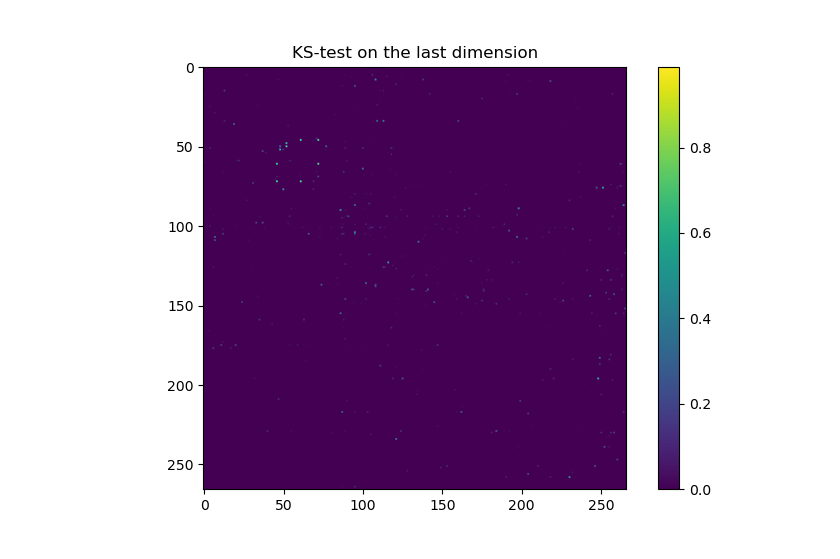

Text(0.5, 1.0, 'KS-test on the last dimension')

In [1377]:
%matplotlib notebook
plt.imshow(test_matches)
plt.colorbar()
plt.title("KS-test on the last dimension")

In [1378]:
# for i in range(dat.shape[0]):
#     c = np.count_nonzero(dat[i,:])
#     if c > 0:
#         print(i,c)

In [1385]:
DG = nx.from_numpy_array(test_matches)
DG[0]

AtlasView({18: {'weight': 0.06487742119542396}, 60: {'weight': 0.09600153787004984}})

<IPython.core.display.Javascript object>


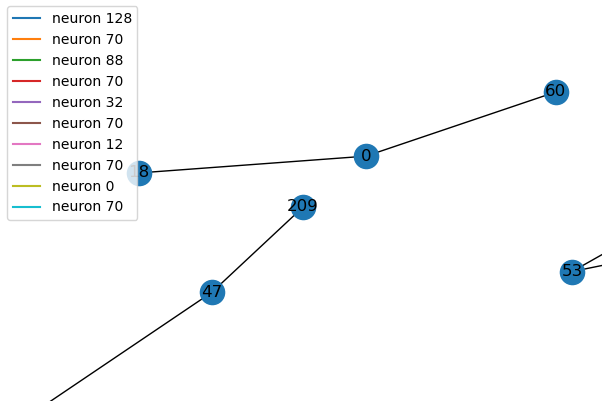

In [1387]:
nx.draw(DG, with_labels=True)

In [1398]:
print(get_indices_of_tracklet(60))
print(get_indices_of_tracklet(0))
print(get_indices_of_tracklet(18))

[50, 51, 52, 53, 54, 55, 56]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]
[19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]


In [1400]:
visualize_tracklet_in_body([60, 0, 18], 51, True)

51 is not in tracklet; try one of 1083                         [50, 51, 52, 53, 54, 55, 56]
10      [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
749     [19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 3...
Name: slice_ind, dtype: object


PointCloud with 151 points.

In [1158]:
from ipywidgets import interact
from scipy.stats import ks_2samp

%matplotlib inline
def f(which_space=0, which_other=1):
    t = all_transformers[which_space]
    c = all_classifiers[which_space]
    if which_space in all_feature_subsets:
        s = all_feature_subsets[which_space]
    else:
        s = None
    
    plt.figure()
    x = all_tracklet_features[which_space]
    if s is not None:
        x = np.array(x)[:,s]
    x_t0 = t.transform(x)
    plt.scatter(x_t0[:,-1],x_t0[:,-2], label='original')
    
    x = all_tracklet_features[which_other]
    if s is not None:
        x = np.array(x)[:,s]
    x_t1 = t.transform(x)
    plt.scatter(x_t1[:,-1],x_t1[:,-2], label='other')
    plt.legend()
    
    # Get predictions of outlier proportion
    pred = c.predict(x_t1[:,-2:])
    conf = round(np.count_nonzero(pred==1)/len(pred),2)
    
    # Also just do a ks test
    ks, p0 = ks_2samp(x_t0[:,-1], x_t1[:,-1])
    p0 = round(p0,3)
    ks, p1 = ks_2samp(x_t0[:,-2], x_t1[:,-2])
    p1 = round(p1,3)
    
    plt.title(f"Proportion of inliers: {conf}; 2 KS tests {p0}; {p1}")

span = (0,len(all_tracklet_features)-1)
interact(f, which_space=span, which_other=span)

interactive(children=(IntSlider(value=0, description='which_space', max=265), IntSlider(value=1, description='…

<function __main__.f(which_space=0, which_other=1)>

In [1157]:
from ipywidgets import interact
from scipy.stats import ks_2samp

%matplotlib inline
def f(which_space=0, which_other=1):
    t = all_transformers[which_space]
    c = all_classifiers[which_space]
    if which_space in all_feature_subsets:
        s = all_feature_subsets[which_space]
    else:
        s = None
    
    plt.figure()
    x = all_tracklet_features[which_space]
    if s is not None:
        x = np.array(x)[:,s]
    x_t0 = t.transform(x)
    plt.scatter(x_t0[:,0],x_t0[:,1], label='original')
    
    x = all_tracklet_features[which_other]
    if s is not None:
        x = np.array(x)[:,s]
    x_t1 = t.transform(x)
    plt.scatter(x_t1[:,0],x_t1[:,1], label='other')
    plt.legend()
    
    # Get predictions of outlier proportion
    pred = c.predict(x_t1[:,-2:])
    conf = round(np.count_nonzero(pred==1)/len(pred),2)
    
    # Also just do a ks test
    ks, p0 = ks_2samp(x_t0[:,0], x_t1[:,0])
    p0 = round(p0,3)
    ks, p1 = ks_2samp(x_t0[:,1], x_t1[:,1])
    p1 = round(p1,3)
    
    plt.title(f"TOP PCA modes; Proportion of inliers: {conf}; 2 KS tests {p0}; {p1}")

span = (0,len(all_tracklet_features)-1)
interact(f, which_space=span, which_other=span)

interactive(children=(IntSlider(value=0, description='which_space', max=265), IntSlider(value=1, description='…

<function __main__.f(which_space=0, which_other=1)>

In [1275]:
# Combined graph, only keeping edges that have both directions
DG_raw = nx.DiGraph()
# DG_raw.add_weighted_edges_from(all_matches)
# TEST: use KS-test graph
# dat = test_matches
dat = thresholded_mat
DG_raw = nx.from_numpy_array(dat)
min_weight = 0.1

must_exist_both_directions = False

DG = nx.DiGraph()
for node in DG_raw:
    for ngbr in nx.neighbors(DG_raw, node):
        # Edge only exists if it exists in both directions originally
        if must_exist_both_directions:
            if node > ngbr:
                continue
            if node in nx.neighbors(DG_raw, ngbr):
                weight = DG_raw.edges[node, ngbr]['weight'] * DG_raw.edges[ngbr, node]['weight']
                if weight > min_weight:
                    DG.add_edge(node, ngbr, weight=weight)
        else:
            # Actually add the edge even if only one-way (should be strong)
            weight = DG_raw.edges[node, ngbr]['weight']
            if node in nx.neighbors(DG_raw, ngbr):
                 weight += DG_raw.edges[ngbr, node]['weight']

            if weight > min_weight:
                if node < ngbr:
                    DG.add_edge(node, ngbr, weight=weight)
                else:
                    DG.add_edge(ngbr, node, weight=weight)


In [1276]:
sources = []
sinks = []

for node, out_deg in DG.out_degree():
    if out_deg == 0:
        sinks.append(node)
        
for node, in_deg in DG.in_degree():
    if in_deg == 0:
        sources.append(node)

print("Nodes that are not sources or sinks:")
print(set(DG.nodes()) - set(sinks) - set(sources))

Nodes that are not sources or sinks:
{3, 7, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 26, 28, 29, 31, 34, 35, 36, 38, 39, 41, 42, 43, 44, 47, 52, 54, 55, 56, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 71, 73, 76, 78, 79, 80, 81, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 95, 96, 97, 98, 99, 100, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 127, 128, 129, 130, 135, 136, 137, 138, 139, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 177, 178, 179, 181, 182, 183, 184, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 197, 198, 199, 200, 201, 202, 203, 204, 207, 208, 210, 211, 212, 213, 214, 215, 217, 218, 220, 221, 223, 224, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 239, 241, 244, 245, 246, 247, 251, 252, 253, 259}


In [1277]:
layout = nx.bipartite_layout(DG, sources)
# nx.draw(DG, pos=layout)

In [1278]:
# Position the nodes where their tracklet starts
get_start = lambda i : tracklet_df['slice_ind'].iloc[i][0]
get_end = lambda i : tracklet_df['slice_ind'].iloc[i][-1]
factor = 0.01

DG_extended = DG.copy()
new_node_ind = 1000
final_layout = layout.copy()
for k, v in layout.items():
#     if k in sources:
#         new_x = factor*get_end(k)
#         v[0] = new_x
#     elif k in sinks:
#         new_x = factor*get_start(k)
#         v[0] = new_x
#     else:
#         If an internal tracklet, add both
    x0 = factor*get_start(k)
    x1 = factor*get_end(k)
    new_start_node = new_node_ind + k

    DG_extended.add_edge(new_start_node, k)
    v[0] = x1
    final_layout[new_start_node] = [x0, v[1]]

# Redo the edges so that they end at a tracklet start
to_add = []
to_remove = []
for edge in DG_extended.edges():
    if (edge[0] < new_node_ind) and (edge[1] < new_node_ind):
        # i.e. it is an ind of the original graph
        to_add.append([edge[0], new_node_ind+edge[1]])
        to_remove.append(edge)
DG_extended.remove_edges_from(to_remove)
DG_extended.add_edges_from(to_add)
    
# Set colors
cmap = []
for node in DG_extended:
    if node > new_node_ind:
        cmap.append('green')
    else:
        cmap.append('blue')

<IPython.core.display.Javascript object>


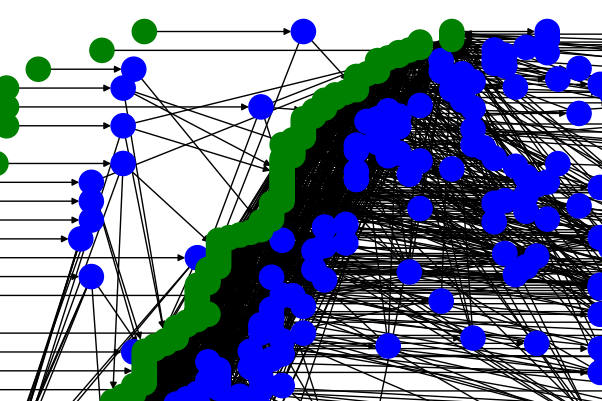

In [1280]:
%matplotlib notebook
nx.draw(DG_extended, pos=final_layout, node_color=cmap)

In [1402]:
# Only keep strongest edge
# The 
# DG_greedy = DG.copy()
# for node in DG_greedy.nodes():
#     print(DG_greedy[node])

## Do conformation matching (of time points)

In [1498]:
# TEST: Do not actually loop

n = len(all_tracklet_features)
all_dist = np.zeros((n,n))
for i0 in tqdm([0]):
    f0 = np.array(all_tracklet_features[i0])
    sigma0 = np.std(f0,axis=0)
    for i1 in [1]:
        f1 = np.array(all_tracklet_features[i1])
        # Match this feature (min of partner)
        f01_dist = []
        for t0 in range(f0.shape[0]):
            t0_dist = []
            v0 = f0[t0,:]/sigma0
#             print("V0 ", np.round(v0,1))
            for t1 in range(f1.shape[0]):
                v1 = f1[t1,:]/sigma0
#                 print("V1 ", np.round(v1,1))
                diff = v1 - v0
#                 print(t1, np.round(diff,2))
                t0_dist.append(np.linalg.norm(diff))
            f01_dist.append(np.min(t0_dist))
        all_dist[i0,i1] = np.mean(f01_dist)


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 111.60it/s]


In [1522]:
visualize_tracklet_in_body([0,1], 55, True)

55 is not in tracklet; try one of [75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162]
55 not in tracklet 1


PointCloud with 152 points.

In [1598]:
from scipy.spatial import distance
# Note: I want something like the Hausdorf distance, but I may have outliers
# Currently I can refactor to use Mahalnoibis distance

n = len(all_tracklet_features)
all_dist = np.zeros((n,n))
all_dist[:] = np.nan
for i0 in tqdm(range(n)):
    f0 = np.array(all_tracklet_features[i0])
    sigma0 = np.std(f0,axis=0)
    for i1 in range(i0+1, n):
        f1 = np.array(all_tracklet_features[i1])
        # Match this feature (min of partner)
        f01_dist = []
        for t0 in range(f0.shape[0]):
            t0_dist = []
            v0 = f0[t0,:]
            for t1 in range(f1.shape[0]):
                v1 = f1[t1,:]
                diff = (v1 - v0)/sigma0
                t0_dist.append(np.linalg.norm(diff))
#                 t0_dist.append(distance.cosine(v0, f1[t1,:]))
            f01_dist.append(np.min(t0_dist))
        all_dist[i0,i1] = np.mean(f01_dist)
        # FOR NOW: force symmetry
        all_dist[i1,i0] = np.mean(f01_dist)
#         all_dist[i0,i1] = np.mean(np.min(distance.cdist(f0, f1), axis=1))

100%|█████████████████████████████████████████████████████████████████████████████████| 191/191 [00:49<00:00,  3.86it/s]


In [1599]:
edges = []
for i_row in range(all_dist.shape[0]):
    r = all_dist[i_row,:]
    try:
        edges.append([i_row, np.nanargmin(r), np.nanmin(r)])
    except:
        pass
DG = nx.DiGraph()
DG.add_weighted_edges_from(edges)

<IPython.core.display.Javascript object>


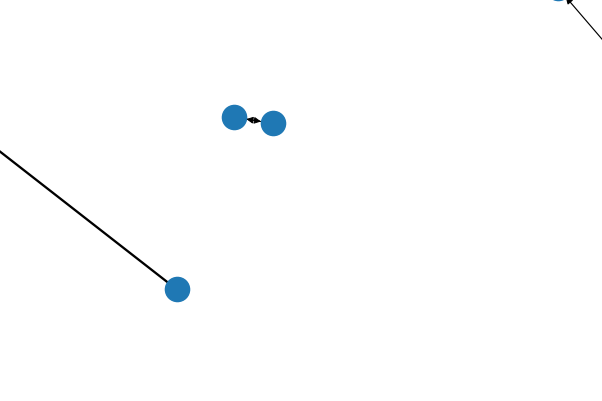

In [1610]:
%matplotlib notebook
e = DG.edges()
weights = [DG[u][v]['weight']/10 for u,v in e]

nx.draw(DG, width=weights)

In [1606]:
i = 0
n0, n1, d = edges[i]
print(n0, n1, d)
print(get_indices_of_tracklet(n0))
print(get_indices_of_tracklet(n1))
visualize_tracklet_in_body([n0, n1], 240, True)

0 162 13.664381510521807
[21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231

PointCloud with 147 points.

<IPython.core.display.Javascript object>


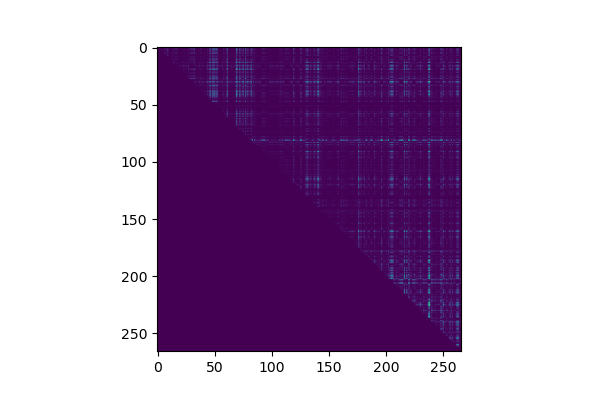

In [1450]:
%matplotlib notebook
plt.imshow(all_dist)

In [1425]:
visualize_tracklet_in_body([77], 55, True)

55 is not in tracklet; try one of 1118    [51, 52, 53, 54, 55, 56, 57, 58, 59]
Name: slice_ind, dtype: object


PointCloud with 152 points.

## Visualize the stable subspaces

In [474]:
all_t, all_c = [], []
for x in all_tracklet_features:
    t, c = calc_one_stable_space(x)
    all_t.append(t)
    all_c.append(c)


C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\covariance\_robust_covariance.py:171: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-50.301897173641642 > -50.349798057298493). You may want to try with a higher value of support_fraction (current value: 0.579).
  RuntimeWarning)
C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\covariance\_robust_covariance.py:171: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-44.259775565671028 > -44.276847673967843). You may want to try with a higher value of support_fraction (current value: 0.667).
  RuntimeWarning)
C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\covariance\_robust_covariance.py:171: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-46.417012113515710 > -46.4320457310344

C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\covariance\_robust_covariance.py:171: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-44.713113952321933 > -45.261798935203927). You may want to try with a higher value of support_fraction (current value: 0.615).
  RuntimeWarning)
C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\covariance\_robust_covariance.py:171: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-36.646346015522688 > -38.393351889239682). You may want to try with a higher value of support_fraction (current value: 0.667).
  RuntimeWarning)
C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\covariance\_robust_covariance.py:171: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-36.646346015522688 > -37.6957038385268

C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\covariance\_robust_covariance.py:171: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-45.793118105472004 > -46.058750925922844). You may want to try with a higher value of support_fraction (current value: 0.714).
  RuntimeWarning)
C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\covariance\_robust_covariance.py:171: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-41.174969681086715 > -41.607740823276863). You may want to try with a higher value of support_fraction (current value: 0.750).
  RuntimeWarning)
C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\covariance\_robust_covariance.py:171: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-46.716737011816889 > -46.8790315558544

C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\covariance\_robust_covariance.py:171: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-50.017968272184838 > -51.096024896812423). You may want to try with a higher value of support_fraction (current value: 0.565).
  RuntimeWarning)
C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\covariance\_robust_covariance.py:171: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-40.287469014732480 > -40.444511458083930). You may want to try with a higher value of support_fraction (current value: 0.667).
  RuntimeWarning)
C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\covariance\_robust_covariance.py:171: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-40.287469014732480 > -40.3222972955541

C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\covariance\_robust_covariance.py:171: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-52.788292321241521 > -52.820496919908251). You may want to try with a higher value of support_fraction (current value: 0.552).
  RuntimeWarning)
C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\covariance\_robust_covariance.py:171: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-52.116451919293020 > -52.135557822910876). You may want to try with a higher value of support_fraction (current value: 0.577).
  RuntimeWarning)
C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\covariance\_robust_covariance.py:171: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-41.457687704883433 > -41.6173200498985

C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\covariance\_robust_covariance.py:171: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-46.843357860234690 > -46.981193425166708). You may want to try with a higher value of support_fraction (current value: 0.588).
  RuntimeWarning)
C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\covariance\_robust_covariance.py:171: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-46.843357860234690 > -47.131125826295658). You may want to try with a higher value of support_fraction (current value: 0.588).
  RuntimeWarning)
C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\covariance\_robust_covariance.py:171: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-46.843357860234690 > -47.2243981524075

C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\covariance\_robust_covariance.py:171: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-42.479909970317493 > -42.715676735124035). You may want to try with a higher value of support_fraction (current value: 0.700).
  RuntimeWarning)
C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\covariance\_robust_covariance.py:171: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-46.146239091571324 > -46.225528302832700). You may want to try with a higher value of support_fraction (current value: 0.667).
  RuntimeWarning)
C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\covariance\_robust_covariance.py:171: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-43.488749018391921 > -44.0247021931511

<IPython.core.display.Javascript object>


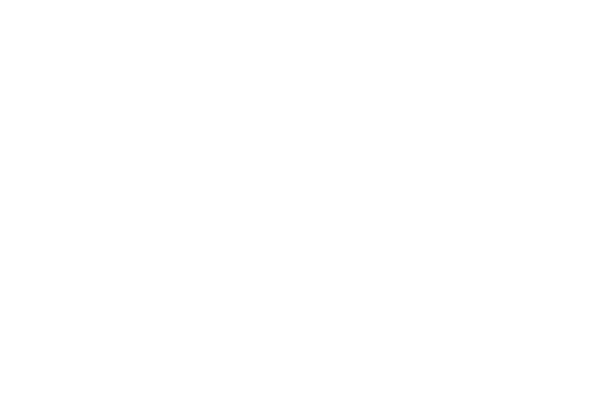

Text(0.5, 1.0, 'All neurons in the stable space of neuron 1')

In [475]:
%matplotlib notebook
which_space = 1
t = all_t[which_space]
num_tracks = 50

all_x = []
for i,x in enumerate(all_tracklet_features):
    if i > num_tracks:
        break
    if i == which_space:
        label = 'original'
    else:
        label = f'neuron{i}'
    x_t = t.transform(x)
    plt.scatter(x_t[:,-2],x_t[:,-1], label=label)
    
plt.legend()
plt.title(f"All neurons in the stable space of neuron {which_space}")

In [484]:
from ipywidgets import interact
%matplotlib inline
def f(which_space=0, which_other=1):
    t = all_t[which_space]
    c = all_c[which_space]
    
    plt.figure()
    x = all_tracklet_features[which_space]
    x_t = t.transform(x)
    plt.scatter(x_t[:,-1],x_t[:,-2], label='original')
    
    x = all_tracklet_features[which_other]
    x_t = t.transform(x)
    plt.scatter(x_t[:,-1],x_t[:,-2], label='other')
    plt.legend()
    
    # Get predictions of outlier proportion
    x = all_tracklet_features[which_other]
    x_t = all_t[which_space].transform(x)
    pred = all_c[which_space].predict(x_t[:,-2:])
    conf = np.count_nonzero(pred==1)/len(pred)
    plt.title(f"Proportion of inliers: {conf}")

span = (0,len(all_tracklet_features)-1)
interact(f, which_space=span, which_other=span)

interactive(children=(IntSlider(value=0, description='which_space', max=265), IntSlider(value=1, description='…

<function __main__.f(which_space=0, which_other=1)>

In [477]:
which_space = 0
min_conf = 0.2
# which_dat = 4

print("Neuron, Confidence, Slices spanned by the tracklet")
for i, which_dat in enumerate(range(len(all_tracklet_features))):
    if i == which_space:
        print("THIS TRACK")
    x = all_tracklet_features[which_dat]
    x_t = all_t[which_space].transform(x)
    pred = all_c[which_space].predict(x_t[:,-2:])
    conf = np.count_nonzero(pred==1)/len(pred)
    if conf > min_conf:
        print(i, conf, tracklet_df.iloc[i]['slice_ind'])
        if i == which_space:
            print("END OF THIS TRACK")
        print("")

Neuron, Confidence, Slices spanned by the tracklet
THIS TRACK
0 0.8461538461538461 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]
END OF THIS TRACK

21 0.3125 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]

91 0.25 [60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]

109 0.42857142857142855 [63, 64, 65, 66, 67, 68, 69]

144 0.25 [69, 70, 71, 72, 73, 74, 75, 76]

145 0.375 [69, 70, 71, 72, 73, 74, 75, 76]

218 0.2222222222222222 [78, 79, 80, 81, 82, 83, 84, 85, 86]

